# Autoregressive Tutorial
Hello. In this tutorial, we are going to learn how to use autoregressive modeling for time-series models.  What this class does is that it makes predictions using a linear combination of past data. 

To describe it more deeply, a model we are used to using for predicting values is the linear regression model: y = a*x + b. How about instead, we predict values based on previous values? For example, how about we predict the value at the current time stamp based on the observed values at the previous two time stamps: X(t) = a*X(t-1) + b*X(t-2) + c? With autoregressive modeling, we can create a best-fitting model of this type.

Before we begin, you are going to need to save this Notebook and then place the file into a folder. Then, you are going to need to download the dataset from https://www.kaggle.com/muthuj7/weather-dataset and save it to the same folder. 

Now, let's import the classes we need for this project:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import lag_plot,autocorrelation_plot
import numpy as np
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
%matplotlib inline

Now, we want to import our weather dataset and convert it into a dataframe:

In [3]:
data = pd.read_csv("weatherHistory.csv", usecols = ['Formatted Date', 'Temperature (C)']) 
data = data.set_index('Formatted Date')
data

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556
...,...
2016-09-09 19:00:00.000 +0200,26.016667
2016-09-09 20:00:00.000 +0200,24.583333
2016-09-09 21:00:00.000 +0200,22.038889


I used the usecols command, because the date and temperature is all we need for now. Let's create a visual representation of our data: 

Text(0, 0.5, 'Temperature (C)')

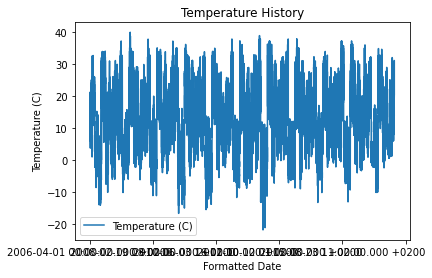

In [4]:
data.plot()
plt.title("Temperature History")
plt.ylabel("Temperature (C)")

Before you proceed, you have to make sure that your data is stationary. If the data is not stationary, then the expected value of each value can vary across different time periods, making it more difficult to predict values. From this graph, the data appears to be stationary. To verify this, you need to use ADF testing. Here is the code for ADF testing (note that this code will take some time to finish running): 

In [5]:
series = data['Temperature (C)']
is_stationary = False 
test = series.values
r = adfuller(test)
if(r[0]<r[4]["5%"]):
    is_stationary = True
print(is_stationary)

True


To put it simply, if you have r = adfuller(test), then if r[0]<r[4]["5%"], then the data is likely to be stationary. As you can see from the result, the data is stationary. However, in the case in which it is not, you have to make the data stationary. Here is how you do it: 

In [6]:
if(is_stationary==False):
    data = data.diff()

Note that sometimes, you need to apply diff() more than once to make your data stationary. There are also other transformations that you can apply to make your data stationary, such as np.log(data) and np.sqrt(data).

Now that your data is stationary, you can proceed. From the above graph, there appears to be no strong linear correlation between time and temperature. So, instead of plotting the data against the temperature, let's create a scatter plot that displays values at their current time stamp against the value at the next time stamp. More formally, we want a scatter plot that maps y(t) vs. y(t+1). This helps us get an idea on whether or not there is a correlation. The type of plot is known as a lag-plot. 

Text(0.5, 1.0, 'Lag-plot')

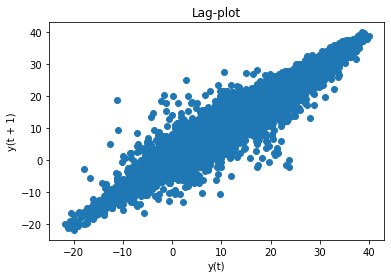

In [7]:
lag_plot(series)
plt.title("Lag-plot")

Now, we seem to be getting a strong correlation between what the value at the current time stamp is and what the value at the next time stamp is. As some of you know, when we do linear regression, there are mathematical values, such as the Pearson correlation coefficient, that help us measure how strong a correlation is. We will use the exact same method here to measure how strong this correlation is: 

In [8]:
data_corr = pd.concat([data.shift(1),data], axis=1)
data_corr

,Temperature (C),Temperature (C)
Formatted Date,,
2006-04-01 00:00:00.000 +0200,NaN,9.472222
2006-04-01 01:00:00.000 +0200,9.472222,9.355556
2006-04-01 02:00:00.000 +0200,9.355556,9.377778
2006-04-01 03:00:00.000 +0200,9.377778,8.288889
2006-04-01 04:00:00.000 +0200,8.288889,8.755556
...,...,...
2016-09-09 19:00:00.000 +0200,28.838889,26.016667
2016-09-09 20:00:00.000 +0200,26.016667,24.583333
2016-09-09 21:00:00.000 +0200,24.583333,22.038889


This dataset is created because we want to put the values of y(t) next to the values of y(t+1) so the correlation between y(t) and y(t+1) can be calculated. 

In [9]:
data_corr.columns=['t','t+1']
data_corr.corr(method="pearson")

,t,t+1
t,1.000000,0.986717
t+1,0.986717,1.000000


Amazing! The correlation coefficient value of 0.987 indicates a very strong correlation. We can also use similar code to measure the correlation between y(t) and y(t+5):

In [10]:
i = 5
data_corr = pd.concat([data.shift(i),data], axis=1)
data_corr.columns=['t','t+1']
data_corr.corr(method="pearson")

,t,t+1
t,1.000000,0.867069
t+1,0.867069,1.000000


The correlation coefficient of 0.867 indicates that the correlation between y(t) and y(t+5) is strong, but not as strong as the correlation between y(t) and y(t+1)

But why measure only the correlation between y(t) and y(t+i) for only one value of i when we could measure the correlation between y(t) and y(t+i) for lots of values of i at once? Of course, to see all of those correlations at once, we need to create a graph to display all of these values. This kind of plot is called an autoregressive plot and you can create one with just one line of code (Note: It may take some time for this graph to finish creating): 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

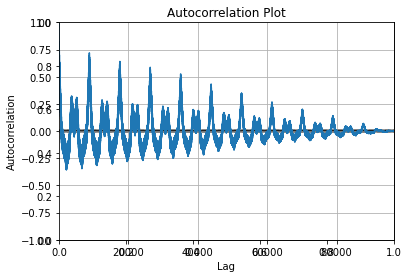

In [11]:
plt.title("Autocorrelation Plot")
autocorrelation_plot(series)

Here is how you interpret this graph: the lag number, which is plotted on the x-axis, is the number of time periods between two different data points. The autocorrelation values, plotted on the y-axis, is how correlated the values are when they are a certain number of time periods apart. An autocorrelation of -1 means a strong negative correlation, 1 means a strong positive correlation and 0 means no correlation. From this graph, you may notice that the autocorrelation gets closer to 0 as the lag increases. This indicates a general trend that as points get further apart, the correlation between them gets smaller.

Since the correlation seems strong at smaller lag values, let's only look at the autoregressive graph at smaller lag values:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


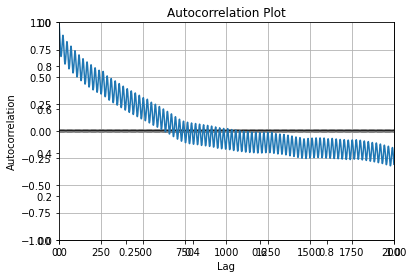

In [12]:
plt.title("Autocorrelation Plot")
x = autocorrelation_plot(series)
x = x.set_xlim([0, 2000])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


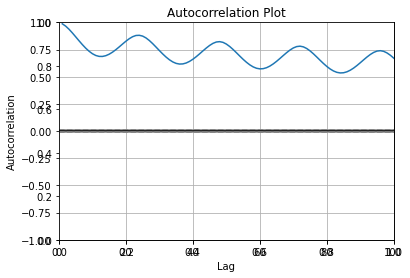

In [13]:
plt.title("Autocorrelation Plot")
x = autocorrelation_plot(series)
x = x.set_xlim([0, 100])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


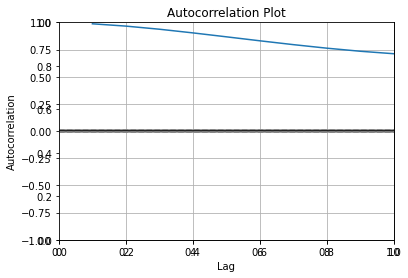

In [14]:
plt.title("Autocorrelation Plot")
x = autocorrelation_plot(series)
x = x.set_xlim([0, 10])

The correlation seems to be highest at a lag of 1. So, points are generally the most correlated when they are only one time interval apart from each other. 

Now, it is time to create our model. First, let's create our training set and our test set. We will first split the data into a training set and a test set, using the first 80% of the points as the testing set and the last 20% of the points as the test set. 

In [15]:
n = len(data)
cut_exact = 0.8*n
cut_rounded = int(cut_exact)
data_train = data[:cut_rounded]
data_test = data[cut_rounded:]
print(data_train)
print(data_test)
print(" ")
print(data.shape)
print(data_train.shape)
print(data_test.shape)

                               Temperature (C)
Formatted Date                                
2006-04-01 00:00:00.000 +0200         9.472222
2006-04-01 01:00:00.000 +0200         9.355556
2006-04-01 02:00:00.000 +0200         9.377778
2006-04-01 03:00:00.000 +0200         8.288889
2006-04-01 04:00:00.000 +0200         8.755556
...                                        ...
2014-11-26 01:00:00.000 +0100         1.738889
2014-11-26 02:00:00.000 +0100         1.622222
2014-11-26 03:00:00.000 +0100         1.161111
2014-11-26 04:00:00.000 +0100        -0.111111
2014-11-26 05:00:00.000 +0100        -0.944444

[77162 rows x 1 columns]
                               Temperature (C)
Formatted Date                                
2014-11-26 06:00:00.000 +0100         0.072222
2014-11-26 07:00:00.000 +0100         0.355556
2014-11-26 08:00:00.000 +0100         1.138889
2014-11-26 09:00:00.000 +0100         2.222222
2014-11-26 10:00:00.000 +0100         2.916667
...                               

Now, we can use the training set we just created to train our autoregression model. Warning: The following code takes a while to finish running. Please wait for the following code to finish running before you proceed.

In [16]:
AR_model = AR(data_train)
fit = AR_model.fit()
print("finished")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:\

finished


Now that we have our model, let's view the parameters: 

In [17]:
lag_value = fit.k_ar
print("lag value:")
print(lag_value)
print(" ")
coeffs = fit.params
print("coefficients:")
print(coeffs)

lag value:
63
 
coefficients:
const                  0.066922
L1.Temperature (C)     0.967518
L2.Temperature (C)     0.061886
L3.Temperature (C)    -0.027058
L4.Temperature (C)    -0.044978
                         ...   
L59.Temperature (C)   -0.011113
L60.Temperature (C)   -0.007590
L61.Temperature (C)    0.002042
L62.Temperature (C)    0.009938
L63.Temperature (C)    0.015060
Length: 64, dtype: float64


This means that the best-fit model found by the program is 
y(t) = 0.066922 + 0.967518*y(t-1) + 0.061886*y(t-2) + ... + 0.015060*y(t-63).

Let's see how accurate this is on the first 100 values after the training set:

In [18]:
left = len(data_train)
right = left+100
sub_preds = fit.predict(start=left, end=right-1)
preds = np.array(sub_preds)
sub_actuals = series[left : right]
actuals = np.array(sub_actuals)
print("predictions:")
print(preds)
print(preds.shape)
print(" ")
print("actuals:")
print(actuals)
print(actuals.shape)

predictions:
[-0.83947662 -0.52254062  0.27712535  1.37628208  2.52007421  3.43143442
  3.94038243  4.33671678  4.56289559  4.60839929  4.63466144  4.48610577
  4.22101394  3.69670291  3.2791293   2.6714124   2.21723848  1.74350148
  1.51626771  1.31557056  1.33142774  1.25007343  1.23818095  1.22427409
  1.34709443  1.66636885  2.20293617  2.88825811  3.6276432   4.34170528
  4.88293878  5.24304593  5.39349277  5.38646389  5.25712796  5.06258206
  4.76211647  4.43648549  4.11487161  3.76245364  3.428596    3.04340334
  2.76312014  2.52732582  2.37445475  2.15342443  1.90266529  1.76234506
  1.84873732  2.19376499  2.71403713  3.37985062  4.09267178  4.74136182
  5.25843672  5.59646489  5.78987986  5.86723747  5.86073997  5.75509928
  5.53030946  5.19319881  4.76288208  4.30554851  3.84286789  3.44645255
  3.12389787  2.89732552  2.72421636  2.60328252  2.53018086  2.54522962
  2.69071443  2.99565392  3.45460239  4.0197264   4.62275457  5.18840854
  5.65059794  5.97461854  6.1556612   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Now that we have our array of predictions and our array of actuals, we can find the mean-squared error:

In [19]:
n = len(actuals)
mse = 0
for i in range(n):
    diff = actuals[i]-preds[i]
    diff_squared = diff*diff
    mse = mse + diff_squared
mse = mse/n 
print("Mean-squared error:")
print(mse)

Mean-squared error:
2.082809035122227


This is a surprisingly low mean-squared error. We now proceed to graph our actuals and predictions.

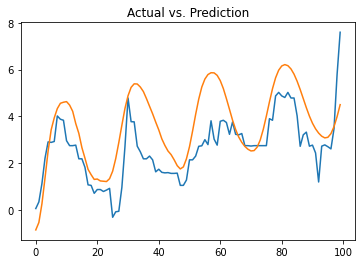

In [20]:
plt.title("Actual vs. Prediction")
plt.plot(actuals,label='actuals')
plt.plot(preds,label='predictions')

As you can see here, our model actually fits quite well in the first 100 values after the training set. 

Unforunately though, if you were to graph the actuals and the predictions for the whole test set, you would see a decrease in accuracy over time. The accuracy of this model can be improved by increasing the size of the training set. 

Another amazing thing that can be done in Python is that the AR model can be combined with a Moving Averages (MA) model. This combination is the AR and MA model is known as the autoregressive integrated moving average (ARIMA) model. I won't be going through the details of MA modeling here. Essentially, what it is is a model that predicts values based on errors on past events. 
The order of an ARIMA model has 3 paremeters: p, d and q. 

p is the number of lags (y(t-1), y(t-2), y(t-3),...) used to predict.

d is how many times you need to apply that diff() function to the data to make it stationary. 

q is the number of lagged forecast errors that are used to model. 

Normally, you would find p by plotting the (stationarized) data on partial autocorrelation plot (a function for it is provided by the statsmodel.api class) and finding the first lag that is below the significance line. Similarly, you would find q by plotting the data on a regular autocorrelation plot and finding the first lag below the significance line. However, for simplification purposes, we will just have p and q equal 1. Since our data was already stationary, d=0.

Now, we will create our model here: 

In [21]:
arima_model = ARIMA(data_train, order=(1,0,1))
arima_fit = arima_model.fit()
print(arima_fit.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                               SARIMAX Results                                
Dep. Variable:        Temperature (C)   No. Observations:                77162
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -143446.576
Date:                Thu, 08 Apr 2021   AIC                         286901.151
Time:                        21:24:17   BIC                         286938.166
Sample:                             0   HQIC                        286912.517
                              - 77162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8382      0.362     32.680      0.000      11.128      12.548
ar.L1          0.9815      0.001   1327.600      0.000       0.980       0.983
ma.L1          0.1980      0.002     99.821      0.0

Finally, let's graph our predictions and actual values:

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


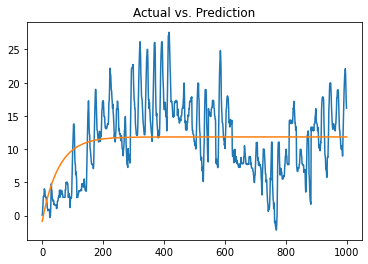

In [22]:
left = len(data_train)
right = left+1000
sub_preds = arima_fit.predict(start=left, end=right-1)
preds = np.array(sub_preds)
sub_actuals = series[left : right]
actuals = np.array(sub_actuals)

plt.title("Actual vs. Prediction")
plt.plot(actuals,label='actuals')
plt.plot(preds,label='predictions')

And there you go! Now, you know how to use autoregression for time-series data in Python.